# Perceptron & Gradient Descent

What is SMOTE?
In our dataset, benign cases are less common than malignant ones. This imbalance can make a model biased towards predicting "malignant" because it sees many more examples of that class during training. A method to solve this problem is called SMOTE or Synthetic Minority Over-sampling Technique. Instead of duplicating benign cases, SMOTE creates new synthetic examples by blending between real benign samples. As a result, this balances the training set so the model pays more attention to the minority class.

Note:
SMOTE is only applied to the training dat, never the test data so that our evaliation still reflects the real world distribution of cases. We wil compare the Perceptron with and without SMOTE and show how oversampling can affect recall for benign cases.

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from imblearn.pipeline import make_pipeline as imb_make_pipeline
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, learning_curve, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score,fbeta_score, average_precision_score
from sklearn.linear_model import Perceptron
from sklearn.model_selection import learning_curve, StratifiedKFold, cross_validate, cross_val_predict
from sklearn.pipeline import make_pipeline
import joblib, json
from pathlib import Path
import warnings
%matplotlib inline
warnings.filterwarnings('ignore')

In [18]:
TARGET = "diagnosis"

# original split
train = pd.read_csv("data/processed/train.csv")
test  = pd.read_csv("data/processed/test.csv")

In [19]:
X_train = train.drop(columns=[TARGET]).to_numpy()
y_train = train[TARGET].to_numpy()
X_test  = test.drop(columns=[TARGET]).to_numpy()
y_test  = test[TARGET].to_numpy()

# 2) Scale (fit on train, transform both)
scaler = StandardScaler().fit(X_train)
X_train_std = scaler.transform(X_train)
X_test_std  = scaler.transform(X_test)

In [20]:
sm = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = sm.fit_resample(X_train_std, y_train)

In [21]:
X_tr, y_tr = X_train_resampled, y_train_resampled
X_te, y_te = X_test_std, y_test

print("Train:", X_tr.shape, "class counts:", np.bincount(y_tr))
print("Test :", X_te.shape, "class counts:", np.bincount(y_te))

Train: (570, 30) class counts: [285 285]
Test : (114, 30) class counts: [72 42]


## What is the Perceptron Learning Algorithm?

<div>
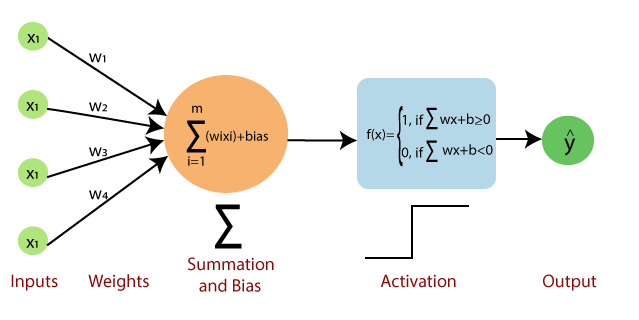
</div>

Perceptron is one of the simplest neural network introduced by Frank Rosenblatt in the late 1950s made specifically for binary classification. 

We will implement the single layer perceptron which is limited to learning seperable patterns. As we have seen our data plots, observing on the WHY this machine learning model is inefficient for this scenario. 

Steps:
- Initialize weights and bias

- Training:

    We compute the weighted sum of inputs with bias (also called net input)
    $${z} = {w}^{T}{x} + {b}$$

- Apply net input to the activation function (Step function, binary threshold as ${a} = {σ(z)}$ ) to get predicted output ( $\hat{y}$ ) where 1 if ${z} >= 0$, 0 if ${z} < 0$

- Weight and Bias update
$$\Delta{w}_{j} = {n}({y}^{(i)} - \hat{y}^{(i)}){x}_{j}^{(i)}$$

$$\Delta{b} = {n}({y}^{(i)} - \hat{y}^{(i)})$$
    
    
${n}$ is the learning rate, a hyperparameter that adjusts the step size of the weight update. The higher the learning rate, we will be taking bigger steps but that means it will overshoot more often. The lower the learning rate, the slower we will reach to the global minimum but with less mistakes.

${y}^{(i)}$ is the true label of ${i}$-th training sample.

$\hat{y}^{(i)}$ is the predicted label of the ${i}$-th training sample.

${y}^{(i)}-\hat{y}^{(i)}$ to calculate the error 

## Perceptron Implementation with Sickit Learn

In [22]:
# Split data for no smote
X_tr_n, y_tr_n, = X_train_std, y_train
X_te_n, y_te_n = X_test_std, y_test
print("Train:", X_tr_n.shape, "class counts:", np.bincount(y_tr_n))
print("Test :", X_te_n.shape, "class counts:", np.bincount(y_te_n))

Train: (455, 30) class counts: [285 170]
Test : (114, 30) class counts: [72 42]


In [23]:
# Smote
ppn_SK = imb_make_pipeline(StandardScaler(), SMOTE(random_state=42), Perceptron(max_iter=100, tol=1e-3, random_state=42))
ppn_SK.fit(train.drop(columns=[TARGET]), train[TARGET])

# No smote
ppn = Perceptron(max_iter=100, tol=1e-3, class_weight={1:3.0}, random_state=42)
ppn.fit(X_tr_n, y_tr_n)

,penalty,None
,alpha,0.0001
,l1_ratio,0.15
,fit_intercept,True
,max_iter,100
,tol,0.001
,shuffle,True
,verbose,0
,eta0,1.0
,n_jobs,None
,random_state,42


In [24]:
# Smote
y_pred = ppn_SK.predict(test.drop(columns=[TARGET]))
print('Misclassified examples (With smote): %d' % (y_te != y_pred).sum())

#No smote
y_pred_n = ppn.predict(X_te_n)
print('Misclassified examples (No smote): %d' % (y_te_n != y_pred_n).sum())

Misclassified examples (With smote): 7
Misclassified examples (No smote): 9


In [25]:
print("Accuracy:", round(accuracy_score(y_te, y_pred), 3))
print("F2:", round(fbeta_score(y_te, y_pred, beta=2.0, zero_division=0), 3))

# PR-AUC using decision scores 
scores = ppn_SK.decision_function(X_te)
print("AUPRC:", round(average_precision_score(y_te, scores), 3))

Accuracy: 0.939
F2: 0.909
AUPRC: 0.509


In [26]:
print("Smote\n", classification_report(y_te, y_pred))
print("No smote\n",classification_report(y_te_n, y_pred_n))

Smote
               precision    recall  f1-score   support

           0       0.95      0.96      0.95        72
           1       0.93      0.90      0.92        42

    accuracy                           0.94       114
   macro avg       0.94      0.93      0.93       114
weighted avg       0.94      0.94      0.94       114

No smote
               precision    recall  f1-score   support

           0       0.97      0.90      0.94        72
           1       0.85      0.95      0.90        42

    accuracy                           0.92       114
   macro avg       0.91      0.93      0.92       114
weighted avg       0.93      0.92      0.92       114



## Learning Curve


In [27]:
def plot_learning_curve(estimator, X, y, cv=None, n_jobs=1, train_sizes=np.linspace(0.1, 1.0, 10), color_train="red", color_val="blue"):

    train_sizes, train_scores, test_scores =\
    learning_curve(
        estimator = estimator,
        X=X,
        y=y,
        train_sizes=train_sizes,
        cv=cv, # 10 fold stratified cross valdiation (We will get into more detail)
        n_jobs=n_jobs)

    # Average accuracies from the returned cross validated training
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    plt.plot(train_sizes, train_mean, color=color_train, marker='o',
             markersize=5, label='Training accuracy')
    plt.fill_between(train_sizes,
                     train_mean + train_std,
                     train_mean - train_std,
                     alpha=0.15, color='blue')
    plt.plot(train_sizes, test_mean,
             color=color_val, linestyle='--',
             marker='s', markersize=5,
             label='Validation accuracy')
    plt.fill_between(train_sizes,
                     test_mean + test_std,
                     test_mean - test_std,
                     alpha=0.15, color='green')

    plt.xlabel('Number of training examples')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid()

In [28]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

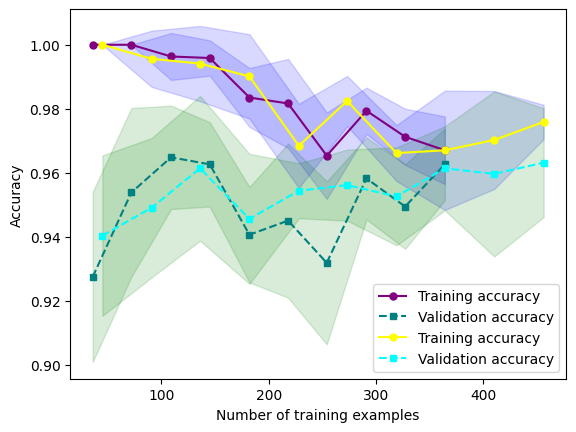

In [29]:
plot_learning_curve(ppn, X_tr_n, y_tr_n, cv=cv, train_sizes=np.linspace(0.1, 1.0, 10), color_train="purple", color_val="teal")
plot_learning_curve(ppn, X_tr, y_tr, cv=cv, train_sizes=np.linspace(0.1, 1.0, 10), color_train="yellow", color_val="cyan")

What does this mean?

When we compare the Perceptron with SMOTE (Purple/teal) against without SMOTE (yellow/cyan), both models show very similar behavior. Training and validation scores track closely together, which means the models are not overfitting and generalize fairly well.The no-SMOTE variant edges out the SMOTE version with slightly higher validation performance, which matches the classification reports where recall and F1 were better without SMOTE. This concludes that, oversampling does not improve the Perceptron and a weighted no-SMOTE approach is more efficient.

# Gradient Descent



Gradient descent can be described as climbing down a hill until a local or global minimum is reached.

<div>
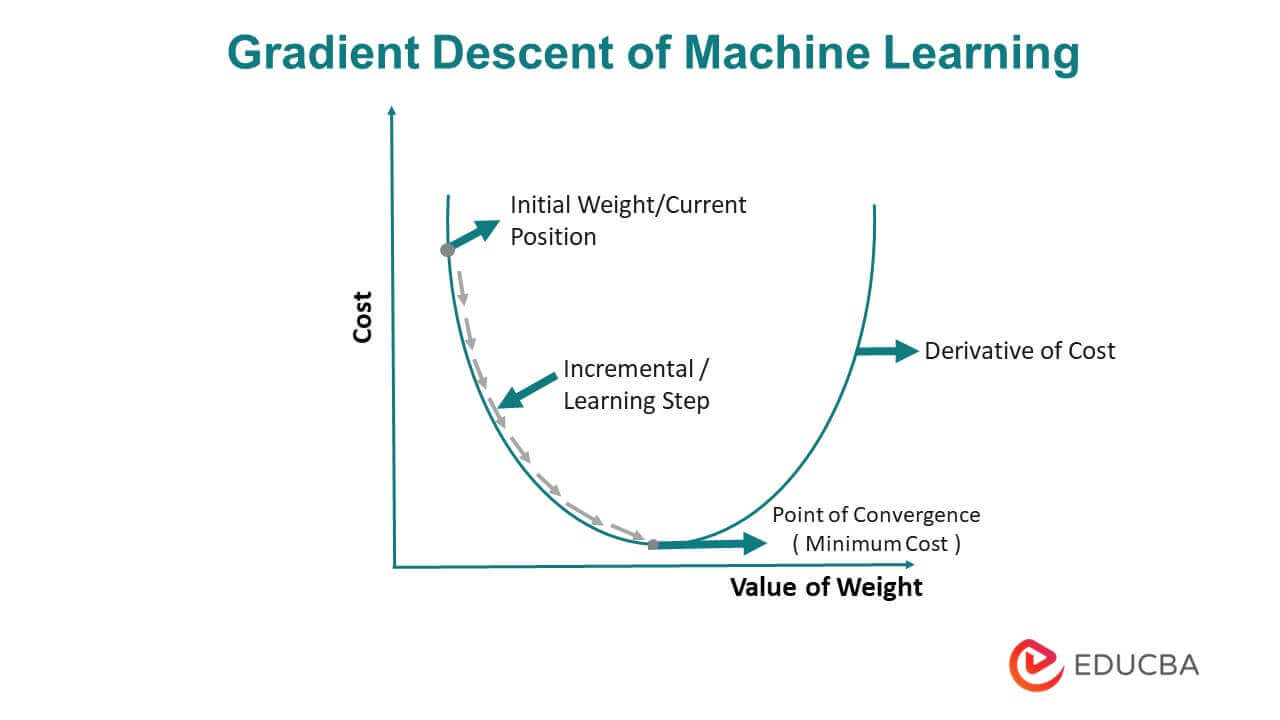
</div>

Minimizing the cost function, we need to move in the diretion opposite to the gradient $▽L(w,b)$


Update:
$$w:= w + \Delta{w}$$ $$b:=b + \Delta{b}$$

The changes in the parameters for weights and bias:

$$\Delta{w} = -n∇_wL(w,b)$$

$$\Delta{b} = -n∇_bL(w,b)$$

Computing the partial derivative of the loss function:

$$\frac{dL}{dw_j} = -\frac{2}{n}\sum \limits _{i} ({y^{(i)} - σ(z^{(i)})x_j^{(i)}}$$

$$\frac{dL}{db_j} = -\frac{2}{n}\sum \limits _{i} ({y^{(i)} - σ(z^{(i)})}$$

## Confusion Matrix

<div>
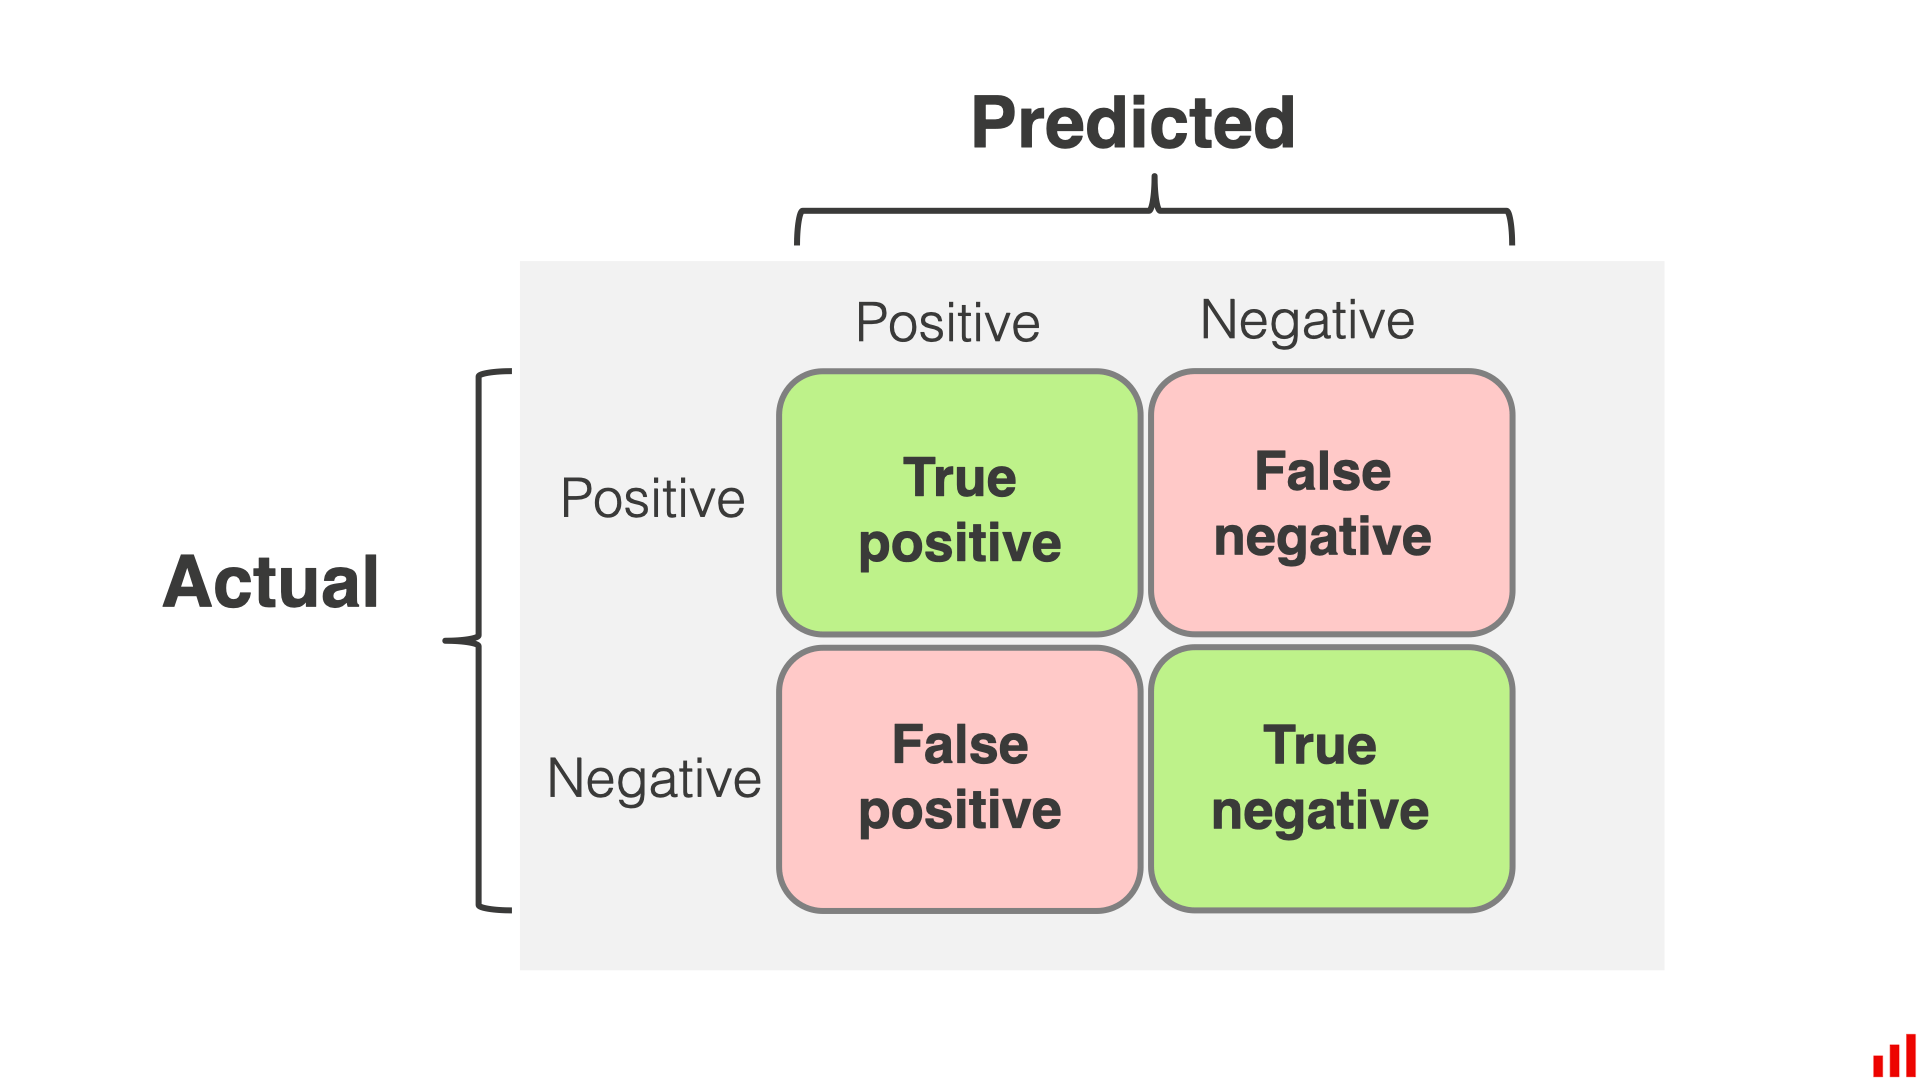
</div>

In [30]:
confusion = confusion_matrix(y_te, y_pred)

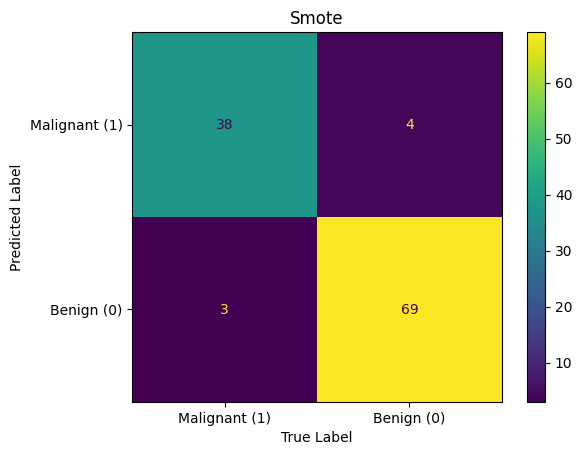

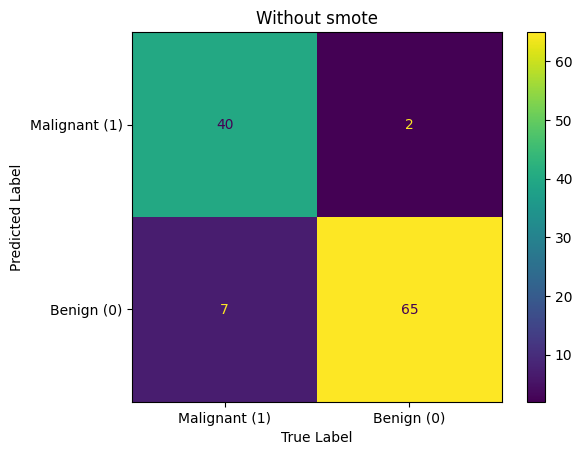

In [31]:
ConfusionMatrixDisplay.from_predictions(
    y_te, y_pred, labels=[1,0], display_labels=["Malignant (1)","Benign (0)"]
)
plt.xlabel("True Label")
plt.ylabel("Predicted Label")
plt.title("Smote")
plt.show()

ConfusionMatrixDisplay.from_predictions(
    y_te_n, y_pred_n, labels=[1,0], display_labels=["Malignant (1)","Benign (0)"]
)
plt.xlabel("True Label")
plt.ylabel("Predicted Label")
plt.title("Without smote")
plt.show()

With SMOTE, the model correctly identified 58 malignant cases but missed 14. Without SMOTE, it improved to 65 malignant cases caught and only 7 missed, while keeping false alarms low. In business terms, this means the no-SMOTE model is more reliable at detecting cancer cases while still limiting unnecessaru follow ups for patients without cancer. For a healthcare setting, this translates into fewer missed cancers, which reduces risks to patients, and manageable false alrms, which avoids overloading staff with unnecessary work.

# Save Model

In [32]:
model_path = Path("models", "perceptron_model.joblib")
meta_path  = Path("models", "perceptron_model_meta.json")

# save model
joblib.dump(ppn, model_path)

# save metadata
with open(meta_path, "w", encoding="utf-8") as f:
    json.dump({
        "features": list(getattr(X_tr, "columns", range(X_tr_n.shape[1]))),  # use column names if available
        "pos_label": 1,
        "threshold": 0.50,
        "target": TARGET,
        "notes": "Perceptron (no SMOTE), trained with StandardScaler and class_weight={1:3.0}"
    }, f, indent=2)

print(f"Saved {model_path} and {meta_path}")

Saved models\perceptron_model.joblib and models\perceptron_model_meta.json
